# **РК2 по дисциплине Технологии машинного обучения**

**Задание(вариант 18):**

Для заданного набора данных (по Вашему варианту) постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения моделей используйте методы 1 и 2 (по варианту для Вашей группы). Оцените качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.

ИУ5-62Б, ИУ5Ц-82Б:	Метод опорных векторов,	Случайный лес.

Датасет: https://www.kaggle.com/datasets/agrafintech/world-happiness-index-and-inflation-dataset

Загрузка библиотек и необходимых модулей

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Загрузка данных

In [3]:
df = pd.read_csv('WHI_Inflation.csv')

# Просмотр первых строк и базовой информации
print(df.head())
print(df.info())
print(df.isnull().sum())

       Country  Year  Headline Consumer Price Inflation  \
0  Afghanistan  2015                             -0.660   
1  Afghanistan  2016                              4.380   
2  Afghanistan  2017                              4.976   
3  Afghanistan  2018                              0.630   
4  Afghanistan  2019                              2.302   

   Energy Consumer Price Inflation  Food Consumer Price Inflation  \
0                        -4.250000                      -0.840000   
1                         2.070000                       5.670000   
2                         4.440000                       6.940000   
3                         1.474185                      -1.045952   
4                        -2.494359                       3.794770   

   Official Core Consumer Price Inflation  Producer Price Inflation  \
0                                0.219999                       NaN   
1                                5.192760                       NaN   
2                

Предобработка данных

In [4]:
# Удаляем строки с пропущенными значениями в целевой переменной
df = df.dropna(subset=['Score'])

Определяем признаки и целевую переменную

In [5]:
X = df.drop(['Score', 'Country'], axis=1)  # Удаляем целевую переменную и идентификатор страны
y = df['Score']

Разделение на категориальные и числовые признаки

In [6]:
categorical_features = ['Continent/Region']
numeric_features = [col for col in X.columns if col not in categorical_features]

Разделение на обучающую и тестовую выборки

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Создание препроцессоров

In [8]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Заполнение пропусков медианой
    ('scaler', StandardScaler())  # Стандартизация числовых признаков
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропусков наиболее частым значением
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot кодирование категориальных признаков
])

Объединение препроцессоров

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Создание и обучение моделей

1. Метод опорных векторов (SVR)

In [10]:
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf'))
])

# Подбор гиперпараметров для SVR
param_grid_svr = {
    'regressor__C': [0.1, 1, 10, 100],
    'regressor__gamma': ['scale', 'auto', 0.1, 0.01]
}

grid_search_svr = GridSearchCV(svr_pipeline, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr.fit(X_train, y_train)

# Выбор лучшей модели SVR
best_svr = grid_search_svr.best_estimator_
print(f"Лучшие параметры SVR: {grid_search_svr.best_params_}")

Лучшие параметры SVR: {'regressor__C': 10, 'regressor__gamma': 'scale'}


2. Случайный лес (Random Forest)

In [11]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Подбор гиперпараметров для Random Forest
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Выбор лучшей модели Random Forest
best_rf = grid_search_rf.best_estimator_
print(f"Лучшие параметры Random Forest: {grid_search_rf.best_params_}")

Лучшие параметры Random Forest: {'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}


Предсказания на тестовой выборке

In [12]:
svr_pred = best_svr.predict(X_test)
rf_pred = best_rf.predict(X_test)

Оценка качества моделей

Метрика 1: Средняя квадратичная ошибка (MSE)

In [13]:
svr_mse = mean_squared_error(y_test, svr_pred)
rf_mse = mean_squared_error(y_test, rf_pred)

Метрика 2: Коэффициент детерминации (R²)

In [14]:
svr_r2 = r2_score(y_test, svr_pred)
rf_r2 = r2_score(y_test, rf_pred)

Метрика 3: Средняя абсолютная ошибка (MAE)

In [15]:
svr_mae = mean_absolute_error(y_test, svr_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

Вывод результатов

In [16]:
print("\nРезультаты оценки моделей:")
print("Метод опорных векторов (SVR):")
print(f"MSE: {svr_mse:.4f}")
print(f"R²: {svr_r2:.4f}")
print(f"MAE: {svr_mae:.4f}")

print("\nСлучайный лес (Random Forest):")
print(f"MSE: {rf_mse:.4f}")
print(f"R²: {rf_r2:.4f}")
print(f"MAE: {rf_mae:.4f}")


Результаты оценки моделей:
Метод опорных векторов (SVR):
MSE: 0.1393
R²: 0.8790
MAE: 0.2656

Случайный лес (Random Forest):
MSE: 0.1627
R²: 0.8587
MAE: 0.3088


Визуализация результатов

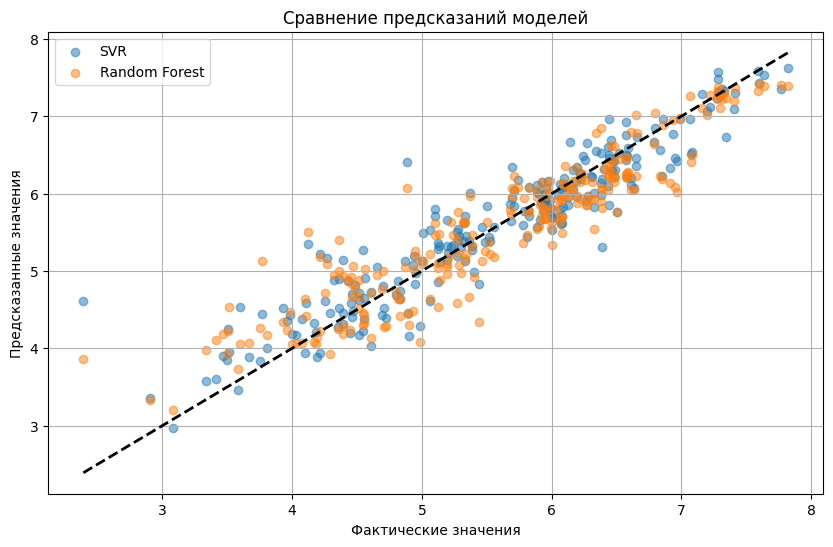

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, svr_pred, alpha=0.5, label='SVR')
plt.scatter(y_test, rf_pred, alpha=0.5, label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний моделей')
plt.legend()
plt.grid(True)
plt.show()

Визуализация важности признаков для Random Forest

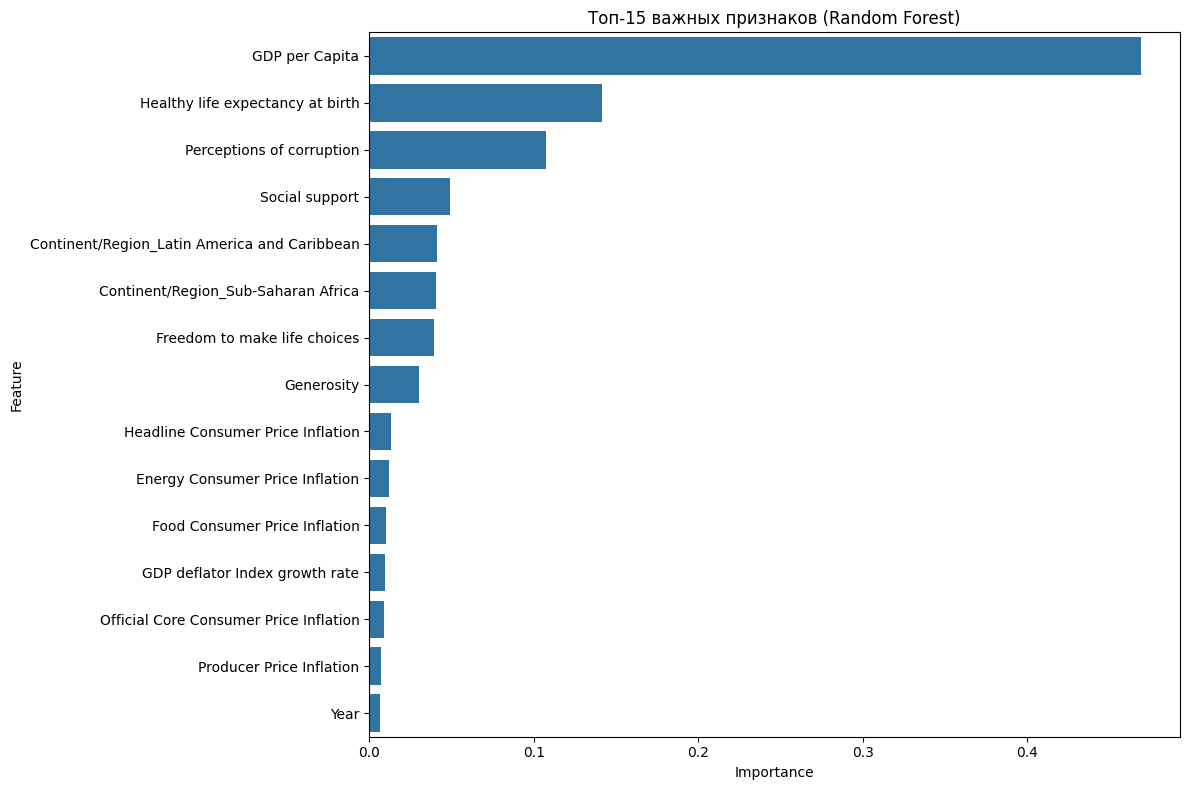

In [18]:
if hasattr(best_rf[-1], 'feature_importances_'):
    # Получение имен признаков после преобразования
    preprocessor = best_rf.named_steps['preprocessor']
    feature_names = []

    for name, trans, cols in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(cols)
        elif name == 'cat':
            # Получение названий закодированных категориальных признаков
            ohe = trans.named_steps['onehot']
            cat_features = ohe.get_feature_names_out(cols)
            feature_names.extend(cat_features)

    importances = best_rf[-1].feature_importances_

    # Создание DataFrame для удобства сортировки
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Визуализация топ-15 важных признаков
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
    plt.title('Топ-15 важных признаков (Random Forest)')
    plt.tight_layout()
    plt.show()

Анализ остатков

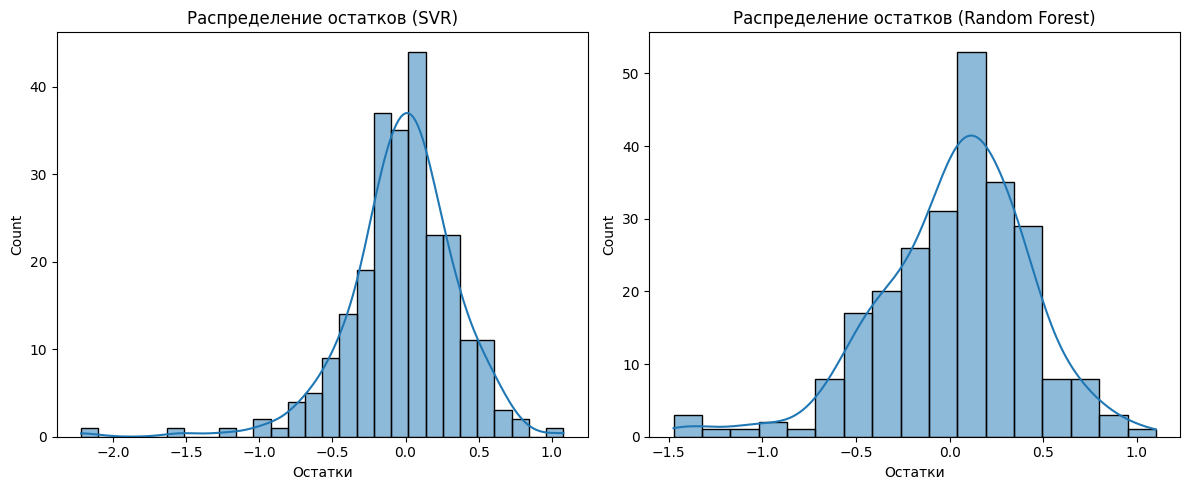

In [19]:
plt.figure(figsize=(12, 5))

# Остатки для SVR
plt.subplot(1, 2, 1)
residuals_svr = y_test - svr_pred
sns.histplot(residuals_svr, kde=True)
plt.title('Распределение остатков (SVR)')
plt.xlabel('Остатки')

# Остатки для Random Forest
plt.subplot(1, 2, 2)
residuals_rf = y_test - rf_pred
sns.histplot(residuals_rf, kde=True)
plt.title('Распределение остатков (Random Forest)')
plt.xlabel('Остатки')

plt.tight_layout()
plt.show()

Сравнение фактических и предсказанных значений

In [20]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'SVR_Predicted': svr_pred,
    'RF_Predicted': rf_pred,
    'SVR_Residuals': residuals_svr,
    'RF_Residuals': residuals_rf
})

print("\nПримеры предсказаний и остатков:")
print(results_df.head(10))


Примеры предсказаний и остатков:
      Actual  SVR_Predicted  RF_Predicted  SVR_Residuals  RF_Residuals
549   4.1200       5.350135      5.502786      -1.230135     -1.382786
1050  7.2840       7.485482      7.328939      -0.201482     -0.044939
244   5.3390       5.446765      5.225187      -0.107765      0.113813
553   5.7900       5.771703      5.941561       0.018297     -0.151561
1165  6.7908       6.662474      6.637771       0.128326      0.153029
907   5.1020       5.712792      5.614744      -0.610792     -0.512744
732   5.2850       5.451921      5.074410      -0.166921      0.210590
526   5.8900       6.015968      5.956664      -0.125968     -0.066664
101   6.9370       6.767037      6.957135       0.169963     -0.020135
128   5.8220       5.713713      5.775080       0.108287      0.046920


Вывод итоговых выводов

In [21]:
# Вывод итоговых выводов
print("\nИтоговые выводы:")
if rf_r2 > svr_r2:
    print(f"Модель Random Forest показала лучшие результаты с R² = {rf_r2:.4f} против R² = {svr_r2:.4f} у SVR.")
    best_model = "Random Forest"
else:
    print(f"Модель SVR показала лучшие результаты с R² = {svr_r2:.4f} против R² = {rf_r2:.4f} у Random Forest.")
    best_model = "SVR"

print(f"\nВыбранные метрики качества:")
print("1. Коэффициент детерминации (R²) - показывает долю дисперсии зависимой переменной, объясняемую моделью.")
print("2. Средняя абсолютная ошибка (MAE) - среднее абсолютное отклонение предсказанных значений от фактических.")
print("3. Средняя квадратичная ошибка (MSE) - среднее квадратов разностей между предсказанными и фактическими значениями.")


Итоговые выводы:
Модель SVR показала лучшие результаты с R² = 0.8790 против R² = 0.8587 у Random Forest.

Выбранные метрики качества:
1. Коэффициент детерминации (R²) - показывает долю дисперсии зависимой переменной, объясняемую моделью.
2. Средняя абсолютная ошибка (MAE) - среднее абсолютное отклонение предсказанных значений от фактических.
3. Средняя квадратичная ошибка (MSE) - среднее квадратов разностей между предсказанными и фактическими значениями.
